<a href="https://colab.research.google.com/github/mshsu/probasets/blob/main/blotter_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blotter Demo

The exponential distribution can be used to model time between instances of independent, regularly occuring events. Let's look at an example of this in real time Cal Poly police reports data from the past 30 days. (More info found [here](https://afd.calpoly.edu/police/campus-reports/logs). This data is updated at around 9AM each day.) Can we model the time between cooking-related incidents in Cal Poly using the exponential distribution?

In [12]:
!pip install symbulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from symbulate import *
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import warnings

In [14]:
warnings.filterwarnings("ignore")

# Scrape

In [15]:
# Query the Cal Poly police logs site for HTML source
response = requests.get("https://afd.calpoly.edu/police/campus-reports/logs")
# Create HTML parser
soup = BeautifulSoup(response.content, "html.parser")
# The data is found in an element denoted by <div class="row align-justify"><\div>
# Within that, it is found in a <table><\table> element
div = soup.find("div", {"class": "row align-justify"})
table = div.find("table")

# Initialize list of data row
rows = []
# Iterate through each row of the table to convert from HTML to dict
# Then dd to rows list
for tr in table.find_all("tr"):
  info = tr.find_all("td")
  if len(info) >= 5:
    # The `Details` column has multiple parts of information
    # This code splits up the `Details` column into other appropriate columns
    details = str(info[3]).replace("<td>", "").replace("</strong>", "").replace("<br/>", "").replace("</td", "").split("<strong>")[1:]
    dets = {"Incident": '', "CAD #": '', "Report #": ''}
    for detail in details:
      detail = detail.split(": ")
      dets[detail[0]] = detail[1]
    # Add info to row dictionary, then add to list
    rows.append({
        "Date/Time Reported": info[0].text,
        "Date/Time Occurred": info[1].text,
        "Location": info[2].text,
        "Incident": dets['Incident'],
        "CAD #": dets['CAD #'].replace(">", ""),
        "Report #": dets['Report #'].replace(">", ""),
        "Disposition": info[4].text
    })

# Turn rows list into tabular dataframe
df_blotter = pd.DataFrame(rows)

## Data

In [16]:
df_blotter

,Date/Time Reported,Date/Time Occurred,Location,Incident,CAD #,Report #,Disposition
0,04/26/2023 12:21 pm,,University Drive,VEHICLE - Vehicle Stop,23-04-26-005886,,DRIVER WARNED/ADVISED
1,04/26/2023 11:30 am,,Pcv Aliso,DISPATCH - 911 Unknown/Abandoned or Hangup,23-04-26-005882,,COMPLETED- NO REPORT
2,04/26/2023 11:02 am,,H2-a Parking Lot,CITIZEN ASSIST - Public Assist (specify),23-04-26-005879,,COMPLETED- NO REPORT
3,04/26/2023 07:34 am,,Canyon Circle,CITIZEN ASSIST - Attempt to Locate/Contact (sp...,23-04-26-005869,,COMPLETED- NO REPORT
4,04/26/2023 07:24 am,,Architecture & Environmental Design Area,LARCENY-THEFT - Theft Report,23-04-26-005868,,COMPLETED- NO REPORT
...,...,...,...,...,...,...,...
2179,02/24/2023 01:44 pm,,Frank E Pilling Computer Science,DOCUMENTATION - Bike Impound,23-02-24-002558,230229,REPORT TAKEN
2180,02/24/2023 01:21 pm,,Mathematics And Science,PROPERTY - Lost Property,23-02-24-002557,,TURNED OVER TO LOST & FOUND
2181,02/24/2023 01:05 pm,02/23/2023 10:00 pm - 02/24/2023 01:08 pm,Tenaya Hall,VANDALISM - Vandalism - Less Than $400,,230228,Closed
2182,02/24/2023 01:05 pm,,Tenaya Hall,VANDALISM - Malicious Mischief report,23-02-24-002556,230228,REPORT TAKEN


## Wrangling

In [17]:
# Filter to cooking related incidents
df_cook = df_blotter[df_blotter['Disposition'].str.lower() == 'false/cooking related']
# Convert Date/Time Reported to datetime format and sort
df_cook['Datetime'] = pd.to_datetime(df_cook['Date/Time Reported'])
df_cook = df_cook.sort_values('Datetime', ignore_index=True)

# Find the time since the last incident for each incident except for the first one
time_before = [0] + list(pd.to_numeric(df_cook['Datetime']))[:-1]
df_cook['Intertime'] = pd.to_numeric(df_cook['Datetime'])-pd.Series(time_before)
df_cook['Intertime Str'] = df_cook['Intertime'].apply(pd.Timedelta)
# Get date and time for each occurrence
df_cook['Date'] = df_cook['Datetime'].dt.date
df_cook['Time'] = df_cook['Datetime'].dt.time
# Filter variables down to the ones we want
df_cook = df_cook[['CAD #', 'Date', 'Time', 'Intertime', 'Intertime Str']][1:]

df_cook

,CAD #,Date,Time,Intertime,Intertime Str
1,23-02-24-002575,2023-02-24,17:28:00,1440000000000,0 days 00:24:00
2,23-02-24-002577,2023-02-24,17:59:00,1860000000000,0 days 00:31:00
3,23-02-24-002579,2023-02-24,18:29:00,1800000000000,0 days 00:30:00
4,23-02-24-002581,2023-02-24,18:59:00,1800000000000,0 days 00:30:00
5,23-02-25-002611,2023-02-25,02:20:00,26460000000000,0 days 07:21:00
...,...,...,...,...,...
186,23-04-24-005780,2023-04-24,20:12:00,39840000000000,0 days 11:04:00
187,23-04-24-005783,2023-04-24,20:49:00,2220000000000,0 days 00:37:00
188,23-04-25-005810,2023-04-25,09:50:00,46860000000000,0 days 13:01:00
189,23-04-25-005849,2023-04-25,20:08:00,37080000000000,0 days 10:18:00


## Rate/Average

In [18]:
beta = df_cook['Intertime'].mean()
lambd = 1/(beta/(1000000000*60*60*24))

print('Avg Time btwn Occurrences: %s\nRate: %.4f Cooking Incidents per Day'
      % (pd.Timedelta(beta), lambd))

Avg Time btwn Occurrences: 0 days 07:35:56.842105263
Rate: 3.1583 Cooking Incidents per Day


## Exponential Distribution

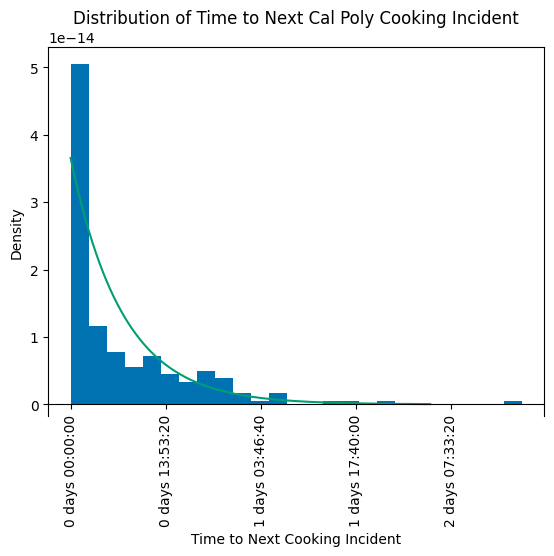

In [19]:
# Plotting the observed data
df_cook['Intertime'].hist(density=True, bins=25, grid=False)
# Plotting the theoretical distribution
Exponential(rate=1/beta).plot()

# Cosmetic stuff
ax = plt.gca()
plt.ylabel(ylabel="Density")
plt.xlabel(xlabel="Time to Next Cooking Incident")
plt.title(label="Distribution of Time to Next Cal Poly Cooking Incident")
xticks = [str(pd.Timedelta(i)) for i in ax.get_xticks()]
ax.set_xticklabels(xticks)
plt.xticks(rotation=90)
xlims = ax.get_xlim()
plt.show()

## Poisson Distribution

In [20]:
# Get frequency of appropriate incidents by date
df_counts = df_cook['Date'].value_counts().to_frame().reset_index().rename(columns={"index": "date", "Date": "freq"})
df_counts = df_counts.sort_values(by="date", ignore_index=True)

# However, the df_counts we just generated doesn't contain days with 0 incidents.
# We need to fix this by generating rows for dates with 0 incidents.
# First, let's find the start and end dates.
start_date = df_counts['date'].min()
end_date = df_counts['date'].max()

# Change the datatype of existing date data to string (for better merging)
df_counts['date'] = df_counts['date'].astype(str)
# Here we generate a dataframe with all dates
all_dates = pd.DataFrame(pd.date_range(start_date, end_date - pd.Timedelta(days = 1), freq='d')).rename(columns={0: 'date'}).astype(str)
# Here we merge the df_counts with the table with all dates
# Then we fill in 0s for dates with no incidents
df_counts = pd.merge(how='left', left=all_dates, right=df_counts, on='date').fillna(0)
df_counts['freq'] = df_counts['freq'].astype(int)

df_counts

,date,freq
0,2023-02-24,4
1,2023-02-25,5
2,2023-02-26,4
3,2023-02-27,5
4,2023-02-28,3
5,2023-03-01,4
6,2023-03-02,5
7,2023-03-03,6
8,2023-03-04,3
9,2023-03-05,7


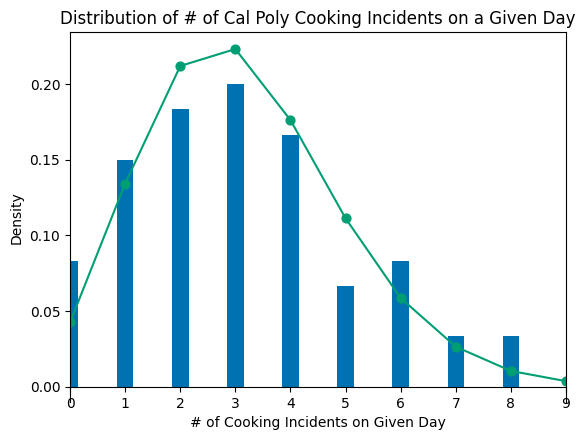

In [21]:
# This makes it so our histogram bar centers line up with the dots on the theoretical distribution
bin_edges=[i+0.5 for i in list(range(min(df_counts["freq"])-1, max(df_counts["freq"])+1, 1))]

# This is the number of days in our timeframe
t=1
# This is our Poisson parameter mu
mu=lambd*t

# Plotting the observed data
df_counts["freq"].hist(density=True, bins=bin_edges, rwidth=0.3, grid=False)
# Plotting the theoretical distribution
Poisson(mu).plot()

# Cosmetic stuff
plt.ylabel(ylabel="Density")
plt.xlabel(xlabel="# of Cooking Incidents on Given Day")
plt.title(label="Distribution of # of Cal Poly Cooking Incidents on a Given Day")
plt.xlim((0,max(df_counts["freq"])+1))
plt.show()